In [1]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"

/albedo/home/pscholz/tripyview
 -> Warming up Numba neighborhood connectivity
 -> Warming up Numba grid kernel
 -> Warming up Numba kernels for vec_r2g
 -> Warming up Numba lsmask compute
 -> Warming up Numba smoothers


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
input_names.append('Tido Test')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'nresol'
year      = [1979, 2019]
mon       = None
day       = None
record    = None 
box       = None
depth     = 1000

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'rygbw'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 1      # number of pannel columns in figure
nrow              = 1
proj              = 'ortho' 
box               = [-30,45] #[-180, 180, -90, 90]
do_plt            = 'tpc'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = np.unique(np.hstack([np.arange(20,100,5), np.arange(100,200,25)]))   # rescale data: None, 'log10', 'slog10', np.array(...)
# do_rescale        = np.unique(np.hstack([np.arange(5,10,0.5), np.arange(10,34,2)]))   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='bluemarble' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = True 
# mesh_opt          = dict({'color':'k', 'linewidth':0.10, 'alpha':0.75})
mesh_opt          = dict({'color':'k', 'linewidth':0.05, 'alpha':0.5})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [3]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem, 
                                       threads_per_worker=parallel_nthread)

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', do_info=True)

# #______________________________________________________________________________________________________
# # create input_path spinupcycle structure
# input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path != None): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)

# #______________________________________________________________________________________________________    
# # concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
# input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)

#______________________________________________________________________________________________________
# use number of worker dependent chunk size for nodes and elements
chunks = dict({'time' : 'auto', 
               'elem' : 'auto', 
               'nod2' : 'auto', 
               'nz1'  : 'auto', 
               'nz'   : 'auto',
               'edg_n': 'auto'})

if client is not None:
    # set size limit of horizontal chunks so that size of the total chunks covers 10% of worker memory
    mem_thresh     = 0.08
    worker_info    = client.run_on_scheduler(lambda dask_scheduler: {worker: ws.memory_limit for worker, ws in dask_scheduler.workers.items()})
    mem_limit_byte = next(iter(worker_info.items()))[1]
    print(' --> worker memory      : {:04.2f}Mb'.format(mem_limit_byte/1024**2))
    print(' --> limit chunksize to : {:04.2f}Mb'.format(mem_limit_byte/1024**2*mem_thresh))
    chunk_size = mem_limit_byte * mem_thresh/4 
    if   chunks['time'] != 'auto': chunk_size = chunk_size/chunks['time']
    if   chunks['nz']   != 'auto': chunk_size = chunk_size/chunks['nz']
    elif chunks['nz1']  != 'auto': chunk_size = chunk_size/chunks['nz1']
    chunks['elem'] = chunks['nod2'] = np.int32(np.ceil(chunk_size))
    print(' --> set elem/nod2 chunk size to {:2.2f}% of worker mem.: {:d}'.format(100*mem_thresh, chunks['elem']))

 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.jlib file: tripyview_mesh_core2_srt_dep@node_focus0.jlib
 > comp. e_resol from triangle height
 > comp n_resol from 2*sqrt(n_area/pi)
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


--> cmin/cmax: norm: 8.015804/171.890996, hist: 12.030746/139.853396, fin: 12.030746/139.853396
[ 20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95 100 125
 150 175] None
{'cstr': 'rygbw', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(12.031), 'cmax': np.float64(139.853), 'cref': np.int64(65), 'cmap': <matplotlib.colors.ListedColormap object at 0x7f907b2583a0>, 'clevel': array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 125, 150, 175]), 'clab': array([ 25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,
        90,  95, 100, 125, 150])}
 --> plot data   chunk:0|
 --> plot mesh   chunk:0|


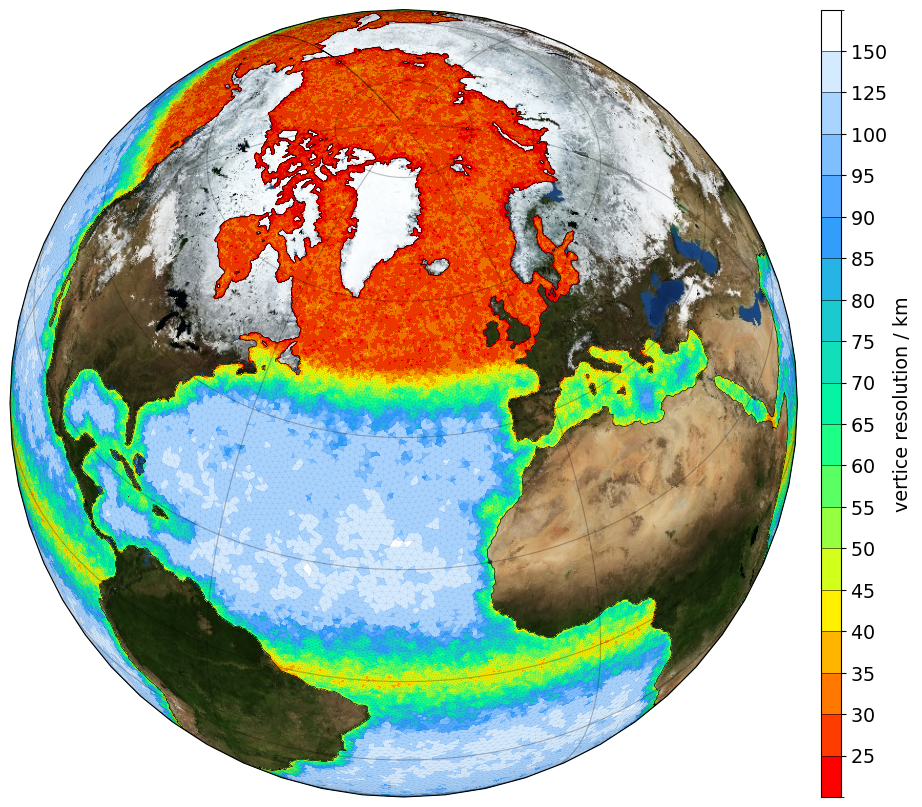

 --> elasped time to plot data: 0.08 min.


In [5]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ts = clock.time()
ndat   = 1
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
svname = vname

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}.{:s}'.format(svname, proj, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
# if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
# else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

    
if do_lsm=='bluemarble' and vname=="None": 
    if mesh_opt['color']=='k' or mesh_opt['color']=='black': mesh_opt.update({'color':'w','linewidth':np.max([0.20,mesh_opt['linewidth']])})    
        
#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hmesh(mesh, vname, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale, 
                                do_mesh=do_mesh, mesh_opt=mesh_opt, do_lsm=do_lsm, 
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':5.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        

In [6]:
if do_papermill and do_parallel and client is not None: client.shutdown()